# qPCR analysis

In [21]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
import scikit_posthocs
# import pygal
import math
import IPython
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import importlib
import svgutils
from svgutils.compose import *
import os.path
from cmcrameri import cm #colormaps

## &Delta;&Delta;C<sub>t</sub> nethod

In [2]:
batlow = cm.vik(range(255))
batlow = batlow[0:255:int(np.floor(255/8)),:]
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=batlow) 

#gene Colors
zfC = {
    'rho'  : '#7d7d7d',
    'sws1' : '#B73AB9',
    'sws2' : '#4364F6',
    'mws1' : '#59CB3B',
    'mws2' : '#59CB3B',
    'mws3' : '#59CB3B',
    'mws4' : '#59CB3B',
    'lws1' : '#CE2A22',
    'lws2' : '#CE2A22',
    'actb2': '#926645',
    'tbx2a': '#c92675',
    'tbx2b': '#7526c9',
    'six7' : '#d6ab00',
}

zfGm = {
    'wt' : 'o',
    'tbx2a' : 'P',
    'tbx2b' : 'X',
    'foxq2' : '^',
}

def formatFigureMain(figH, axH, plotH):
    font_path = '/System/Library/Fonts/Avenir.ttc'
#     fontTicks = font_manager.FontProperties(fname=font_path, size=18)
#     fontLabels = font_manager.FontProperties(fname=font_path, size=22)
#     fontTitle = font_manager.FontProperties(fname=font_path, size=28)
    fontTicks = font_manager.FontProperties(fname=font_path, size=28)
    fontLabels = font_manager.FontProperties(fname=font_path, size=32)
    fontTitle = font_manager.FontProperties(fname=font_path, size=38)
    axH.set_xscale('linear')
    axH.spines['top'].set_visible(False)
    axH.spines['right'].set_visible(False)
    
    for label in (axH.get_xticklabels() + axH.get_yticklabels()):
        label.set_fontproperties(fontTicks)
    axH.set_xlabel(axH.get_xlabel(), fontproperties = fontTicks)
    axH.set_ylabel(axH.get_ylabel(), fontproperties = fontTicks)
    return fontLabels

def formatFigureCt(figH, axH, plotH):
    fontLabels = formatFigureMain(figH, axH, plotH)
    axH.set_xlabel('Sample', fontproperties=fontLabels)
    axH.set_ylabel('Ct', fontproperties=fontLabels)

def formatFigureFD(figH, axH, plotH):
    fontLabels = formatFigureMain(figH, axH, plotH)
    axH.set_xlabel('Sample', fontproperties=fontLabels)
    axH.set_ylabel('Relative Expression', fontproperties=fontLabels)
        
def sumstd (a,b):
    sd = np.sqrt(np.square(a)+np.square(b))
    return sd

def getFD(fName,sampleList,wtList,refGene):
    df = pd.read_csv(fName)
    
    geneList = np.unique(df['Target'])
    dCt={}
    dCt['samples'] = sampleList
    for gene in geneList:
        dCt[gene] = [np.mean(df[(df['Sample']==s) & (df['Target']==gene)].Cq)-np.mean(df[(df['Sample']==s) & (df['Target']==refGene)].Cq) for s in sampleList]
        dCt[(gene+'SD')] = [sumstd(np.std(df[(df['Sample']==s) & (df['Target']==gene)].Cq),np.std(df[(df['Sample']==s) & (df['Target']==refGene)].Cq)) for s in sampleList]
    dCt = pd.DataFrame(dCt)

    ddCt = {}
    ddCt['samples'] = sampleList
    for gene in geneList:
        ddCt[gene] = [dCt[(dCt['samples']==s)][gene].item() - np.mean(dCt[dCt['samples'].str.contains("|".join(wtList))][gene]) for s in sampleList]
        ddCt[(gene+'SD')] = [sumstd(dCt[(dCt['samples']==s)][(gene+'SD')].item(),np.std(dCt[dCt['samples'].str.contains("|".join(wtList))][(gene+'SD')]/np.sqrt(np.size(wtList)))) for s in sampleList]
    ddCt = pd.DataFrame(ddCt)

    fd = {} #fold differences
    fd['samples'] = sampleList
    for gene in geneList:
        fd[gene] = [np.power(2,-ddCt[(ddCt['samples']==s)][gene].item()) for s in sampleList]
        fd[(gene + 'Lo')] = [np.power(2,-(ddCt[(ddCt['samples']==s)][gene].item()-ddCt[(ddCt['samples']==s)][(gene + 'SD')].item())) for s in sampleList]
        fd[(gene + 'Hi')] = [np.power(2,-(ddCt[(ddCt['samples']==s)][gene].item()+ddCt[(ddCt['samples']==s)][(gene + 'SD')].item())) for s in sampleList]
    return pd.DataFrame(fd)

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import colorsys
    try:
        c = matplotlib.colors.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*matplotlib.colors.to_rgb(c))
    return matplotlib.colors.rgb2hex(colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2]))

def estimateJitter(dataArray):
    """ creates random jitter scaled by local density of points"""
    from scipy.stats import gaussian_kde
    kde = gaussian_kde(dataArray)
    density = kde(dataArray)
    jitter = np.random.randn(len(dataArray))*density
    return jitter

print('Loaded!\n')

Loaded!



In [ ]:
# dark background
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w",
         "axes.linewidth" : 3,
         "xtick.major.width" : 3,
         "ytick.major.width" : 3,
         "xtick.major.size" : 8,
         "ytick.major.size" : 8,
         "text.color" : "w"}
plt.rcParams.update(params)

In [3]:
# white background
params = {"ytick.color" : "k",
          "xtick.color" : "k",
          "axes.labelcolor" : "k",
          "axes.edgecolor" : "k",
         "axes.linewidth" : 3,
         "xtick.major.width" : 3,
         "ytick.major.width" : 3,
         "xtick.major.size" : 8,
         "ytick.major.size" : 8,
         "text.color" : "k"}
plt.rcParams.update(params)

In [5]:

# fName = "/Users/angueyraaristjm/Documents/LiMolec/zfqPCR/BioRad/20210322_CRtbx2aF0_Opsins.csv"
# fName = "/Users/angueyraaristjm/Documents/LiMolec/zfqPCR/BioRad/20210326_CRtbx2F0s_opsins.csv"
# fName = "/Users/angueyraaristjm/Documents/LiMolec/zfqPCR/BioRad/20210329_CRtbx2F0s_opsinsAgain.csv"
# fName = "/Users/angueyraaristjm/Documents/LiMolec/zfqPCR/BioRad/20210402_CRtbx2F0s_m2l2s2.csv"
# fName = "/Users/angueyraaristjm/Documents/LiMolec/zfqPCR/BioRad/20210402_CRtbx2F0s_tbx2s2.csv"

dPath = "/Users/angueyraaristjm/Documents/eelMolec/zfqPCR/BioRad/"
# fName = "20210416_CRtbx2F0s_rho_stdC.csv"
fName = "20210419_CRtbx2F0s_rhos1_stdCurve.csv"
fName = "20210419_CRtbx2F0s_rhos1_stdCurve.csv"
fName = "20210505_CRtbx2F0s_tbx2ab_stdCurve.csv"
fName = "20210507_CRtbx2F0s_tbx2ab_stdCurve.csv"
fName = "20210507_CRtbx2F0s_rhos1_stdCurve.csv"



df = pd.read_csv(dPath + fName)
df[df['Target']=='actb2']

,Unnamed: 0,Well,Fluor,Target,Content,Sample,Cq,SQ
0,NaN,A01,SYBR,actb2,Unkn,std01,18.376133,NaN
1,NaN,A02,SYBR,actb2,Unkn,std01,20.203366,NaN
2,NaN,A03,SYBR,actb2,Unkn,std01,22.604063,NaN
3,NaN,A04,SYBR,actb2,Unkn,std01,28.584103,NaN
4,NaN,A05,SYBR,actb2,Unkn,std01,32.964261,NaN
5,NaN,A06,SYBR,actb2,Unkn,std01,18.298456,NaN
6,NaN,A07,SYBR,actb2,Unkn,std01,20.215184,NaN
7,NaN,A08,SYBR,actb2,Unkn,std01,22.617220,NaN
8,NaN,A09,SYBR,actb2,Unkn,std01,28.739254,NaN
9,NaN,A10,SYBR,actb2,Unkn,std01,35.282909,NaN


In [ ]:
np.unique(df['Sample'])

In [7]:
# define wt samples and reference ("house-keeping") gene
hkg = 'actb2'

# samples=['wtL11', 'wtL12', 'wtL13','tbx2aL11', 'tbx2aL12', 'tbx2bL11', 'tbx2bL12',] #re-rorganization
# wtsamples = ['wtL11', 'wtL12', 'wtL13']

# samples=['wtL14', 'wtL15','tbx2aL13', 'tbx2aL14', 'tbx2aL15', 'tbx2bL13','tbx2bL14',] #re-rorganization
# wtsamples = ['wtL14', 'wtL15']

samples=[ 'wtL16', 'wtL17','tbx2aL16', 'tbx2aL17', 'tbx2bL15','tbx2bL16'] #re-rorganization (ntng2b does not have enough cDNA and has a lot of pipetting problerms. Just ignore)
wtsamples = ['wtL16', 'wtL17']

fd = getFD("/Users/angueyraaristjm/Documents/eelMolec/zfqPCR/BioRad/20210507_CRtbx2F0s_six7l1_stdCurve.csv",samples,wtsamples,hkg)
fd


,samples,actb2,actb2Lo,actb2Hi,lws1,lws1Lo,lws1Hi,six7,six7Lo,six7Hi
0,wtL16,1.0,1.112827,0.898612,0.797187,0.865226,0.734499,0.973026,1.237742,0.764925
1,wtL17,1.0,1.134546,0.881410,1.254410,1.375612,1.143887,1.027722,1.151214,0.917476
2,tbx2aL16,1.0,1.106438,0.903802,2.239592,2.475473,2.026188,0.498025,0.550079,0.450897
3,tbx2aL17,1.0,1.080366,0.925613,1.155164,1.231936,1.083177,0.469287,0.515868,0.426912
4,tbx2bL15,1.0,1.060399,0.943041,1.987126,2.199753,1.795051,0.579621,0.649916,0.516928
5,tbx2bL16,1.0,1.126557,0.887660,1.287366,1.707294,0.970724,0.173486,0.195702,0.153792


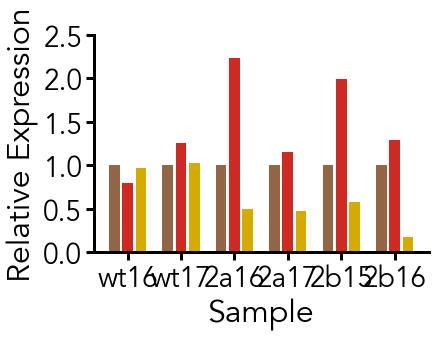

In [8]:
samples = np.unique(df['Sample'])
samples=['wtL11', 'wtL12', 'wtL13','tbx2aL11', 'tbx2aL12', 'tbx2bL11', 'tbx2bL12'] #re-rorganization
samples=['wtL14', 'wtL15','tbx2aL13', 'tbx2aL14', 'tbx2aL15', 'tbx2bL13','tbx2bL14',] #re-rorganization
samples=[ 'wtL16', 'wtL17','tbx2aL16', 'tbx2aL17', 'tbx2bL15','tbx2bL16']

geneList = ['actb2','tbx2a','tbx2b']
geneList = ['actb2','rho','sws1']
geneList = ['actb2','sws2','mws1']
geneList = ['actb2','mws2','lws2']
geneList = ['actb2','lws1','six7']

plotname = ''
fH, axH = plt.subplots()

relW = np.size(geneList)+2;relD = np.size(geneList)+1;relP = -np.size(geneList)+1;
j=relP;
for gene in geneList:
    i=0;
    j=j+1;
    for s in samples:
        i = i+1;
        pH = plt.bar([i+j/relD], fd[(fd['samples']==s)][gene].item(), width=1/relW, color=zfC[gene]);

formatFigureFD(fH, axH, pH)
axH.set_xticks(range(1,np.size(samples)+1));
# axH.set_xticklabels(['wt11','wt12','wt13','2a11','2a12','2b14','2b12']);
# axH.set_xticklabels(['wt14','wt15','2a13','2a14','2a15','2b13','2b14']);
axH.set_xticklabels(['wt16','wt17','2a16','2a17','2b15','2b16']);
axH.set_ylim([0,2.5]);

### tbx2F&empty; from 2021/04/09
> Good RNA yield, switched to standard curve, but &Delta;&Delta;C<sub>t</sub> still works

Trying to accumulate data across plates

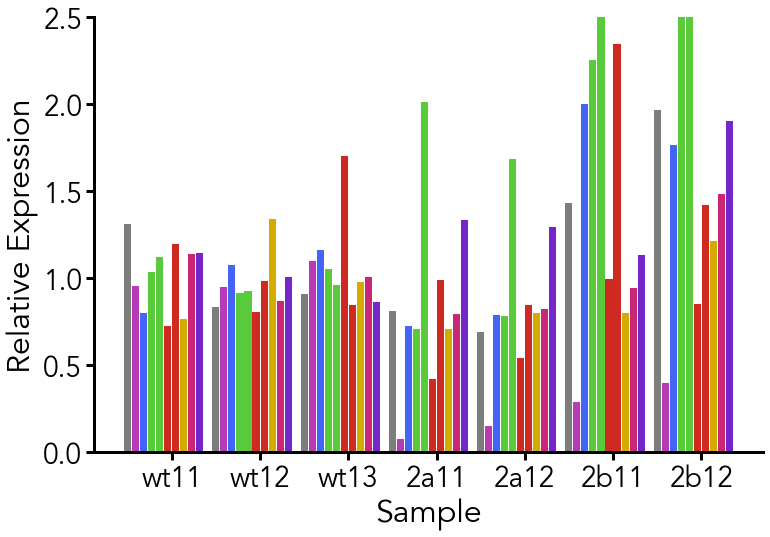

In [10]:
hkg = 'actb2'

samples=['wtL11', 'wtL12', 'wtL13','tbx2aL11', 'tbx2aL12', 'tbx2bL11', 'tbx2bL12',] #re-rorganization
wtsamples = ['wtL11', 'wtL12', 'wtL13']

# for now will drop actb2 since it's normalized anyway and I've done error propagation
fd0 = getFD("/Users/angueyraaristjm/Documents/eelMolec/zfqPCR/BioRad/20210419_CRtbx2F0s_rhos1_stdCurve.csv",samples,wtsamples,hkg)
fd0 = fd0.drop(labels=["actb2","actb2Lo","actb2Hi"], axis=1)
fd1 = getFD("/Users/angueyraaristjm/Documents/eelMolec/zfqPCR/BioRad/20210419_CRtbx2F0s_m2l2_stdCurve.csv",samples,wtsamples,hkg)
fd1 = fd1.drop(labels=["actb2","actb2Lo","actb2Hi"], axis=1)
fd2 = getFD("/Users/angueyraaristjm/Documents/eelMolec/zfqPCR/BioRad/20210419_CRtbx2F0s_s2m1_stdCurve.csv",samples,wtsamples,hkg)
fd2 = fd2.drop(labels=["actb2","actb2Lo","actb2Hi"], axis=1)
fd3 = getFD("/Users/angueyraaristjm/Documents/eelMolec/zfqPCR/BioRad/20210419_CRtbx2F0s_six7l1_stdCurve.csv",samples,wtsamples,hkg)
fd3 = fd3.drop(labels=["actb2","actb2Lo","actb2Hi"], axis=1)
fd4 = getFD("/Users/angueyraaristjm/Documents/eelMolec/zfqPCR/BioRad/20210505_CRtbx2F0s_tbx2ab_stdCurve.csv",samples,wtsamples,hkg)
fd4 = fd4.drop(labels=["actb2","actb2Lo","actb2Hi"], axis=1)
# fd5 = getFD("/Users/angueyraaristjm/Documents/LiMolec/zfqPCR/BioRad/20210507_CRtbx2F0s_tbx2ab_stdCurve.csv",samples,wtsamples,hkg)
# fd5 = fd5.drop(labels=["actb2","actb2Lo","actb2Hi"], axis=1)

fd = pd.merge(fd0, fd1, on="samples")
fd = pd.merge(fd, fd2, on="samples")
fd = pd.merge(fd, fd3, on="samples")
fd = pd.merge(fd, fd4, on="samples")
# fd = pd.merge(fd, fd5, on="samples")
fd


geneList = ['rho','sws1','sws2','mws1','mws2','lws1','lws2','six7','tbx2a','tbx2b']
plotname = ''
fH, axH = plt.subplots(figsize=[12,8])

relW = np.size(geneList)+2.5;relD = np.size(geneList)+1;relP = -np.size(geneList)+3.5;
j=relP;
for gene in geneList:
    i=0;
    j=j+1;
    for s in samples:
        i = i+1;
        pH = plt.bar([i+j/relD], fd[(fd['samples']==s)][gene].item(), width=1/relW, color=zfC[gene]);


formatFigureFD(fH, axH, pH)
axH.set_xticks(range(1,np.size(samples)+1));
axH.set_xticklabels(['wt11','wt12','wt13','2a11','2a12','2b11','2b12']);
axH.set_ylim([0,2.5]);

### normalize by WT average

KeyError: 'actb2'

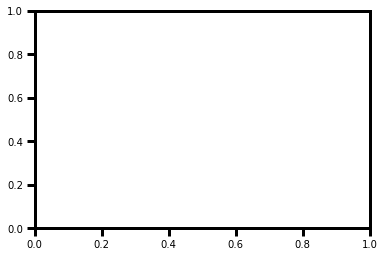

In [11]:
hkg = 'actb2'

samples=['wtL11', 'wtL12', 'wtL13','tbx2aL11', 'tbx2aL12', 'tbx2bL11', 'tbx2bL12',] #re-rorganization
wtsamples = ['wtL11', 'wtL12', 'wtL13']
fdm2l2 = getFD("/Users/angueyraaristjm/Documents/eelMolec/zfqPCR/BioRad/20210419_CRtbx2F0s_m2l2_stdCurve.csv",samples,wtsamples,hkg)


samples = np.unique(df['Sample'])
samples=['wtL11', 'wtL12', 'wtL13','tbx2aL11', 'tbx2aL12', 'tbx2bL11', 'tbx2bL12'] #re-rorganization

geneList = ['actb2','mws2','lws2']

plotname = ''
fH, axH = plt.subplots()

relW = np.size(geneList)+2;relD = np.size(geneList)+1;relP = -np.size(geneList)+1;
j=relP;
for gene in geneList:
    i=0;
    j=j+1;
    for s in samples:
        i = i+1;
        pH = plt.bar([i+j/relD], fd[(fd['samples']==s)][gene].item(), width=1/relW, color=zfC[gene]);


formatFigureFD(fH, axH, pH)
axH.set_xticks(range(1,np.size(samples)+1));
axH.set_xticklabels(['wt11','wt12','wt13','2a11','2a12','2b114','2b12']);
axH.set_ylim([0,2.5]);

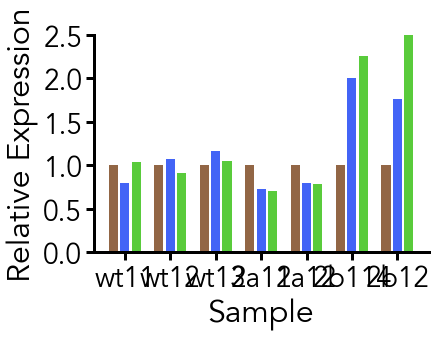

In [12]:
# define wt samples and reference ("house-keeping") gene
hkg = 'actb2'

samples=['wtL11', 'wtL12', 'wtL13','tbx2aL11', 'tbx2aL12', 'tbx2bL11', 'tbx2bL12',] #re-rorganization
wtsamples = ['wtL11', 'wtL12', 'wtL13']
fd = getFD("/Users/angueyraaristjm/Documents/eelMolec/zfqPCR/BioRad/20210419_CRtbx2F0s_s2m1_stdCurve.csv",samples,wtsamples,hkg)


samples = np.unique(df['Sample'])
samples=['wtL11', 'wtL12', 'wtL13','tbx2aL11', 'tbx2aL12', 'tbx2bL11', 'tbx2bL12'] #re-rorganization

geneList = ['actb2','sws2','mws1']

plotname = ''
fH, axH = plt.subplots()

relW = np.size(geneList)+2;relD = np.size(geneList)+1;relP = -np.size(geneList)+1;
j=relP;
for gene in geneList:
    i=0;
    j=j+1;
    for s in samples:
        i = i+1;
        pH = plt.bar([i+j/relD], fd[(fd['samples']==s)][gene].item(), width=1/relW, color=zfC[gene]);


formatFigureFD(fH, axH, pH)
axH.set_xticks(range(1,np.size(samples)+1));
axH.set_xticklabels(['wt11','wt12','wt13','2a11','2a12','2b114','2b12']);
axH.set_ylim([0,2.5]);

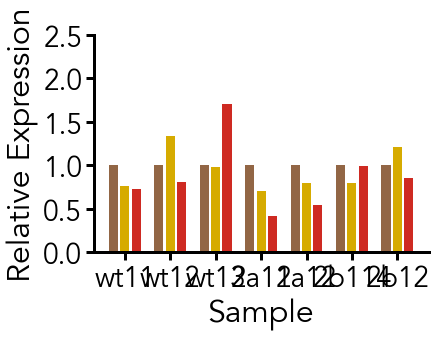

In [13]:
# define wt samples and reference ("house-keeping") gene
hkg = 'actb2'

samples=['wtL11', 'wtL12', 'wtL13','tbx2aL11', 'tbx2aL12', 'tbx2bL11', 'tbx2bL12',] #re-rorganization
wtsamples = ['wtL11', 'wtL12', 'wtL13']
fd = getFD("/Users/angueyraaristjm/Documents/eelMolec/zfqPCR/BioRad/20210419_CRtbx2F0s_six7l1_stdCurve.csv",samples,wtsamples,hkg)


samples = np.unique(df['Sample'])
samples=['wtL11', 'wtL12', 'wtL13','tbx2aL11', 'tbx2aL12', 'tbx2bL11', 'tbx2bL12'] #re-rorganization

geneList = ['actb2','six7','lws1']

plotname = ''
fH, axH = plt.subplots()

relW = np.size(geneList)+2;relD = np.size(geneList)+1;relP = -np.size(geneList)+1;
j=relP;
for gene in geneList:
    i=0;
    j=j+1;
    for s in samples:
        i = i+1;
        pH = plt.bar([i+j/relD], fd[(fd['samples']==s)][gene].item(), width=1/relW, color=zfC[gene]);


formatFigureFD(fH, axH, pH)
axH.set_xticks(range(1,np.size(samples)+1));
axH.set_xticklabels(['wt11','wt12','wt13','2a11','2a12','2b114','2b12']);
axH.set_ylim([0,2.5]);

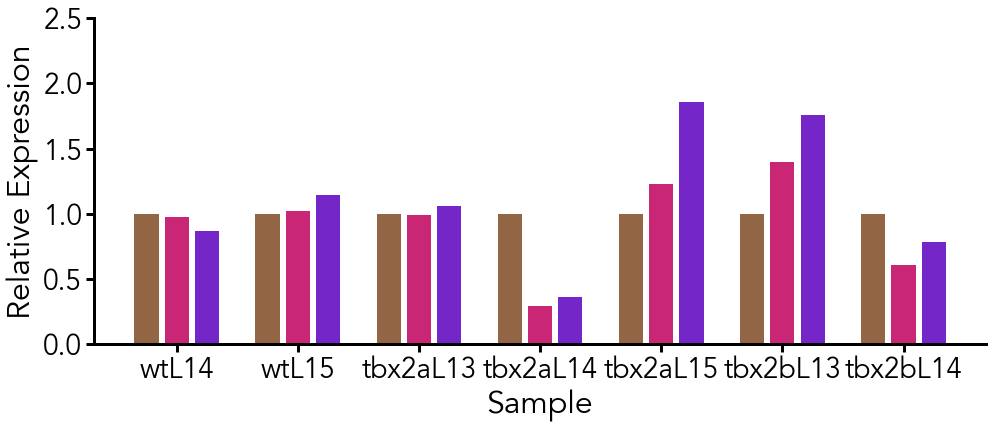

In [14]:


# define wt samples and reference ("house-keeping") gene
hkg = 'actb2'

samples=['wtL14', 'wtL15', 'tbx2aL13', 'tbx2aL14', 'tbx2aL15', 'tbx2bL13', 'tbx2bL14']
wtsamples = ['wtL14', 'wtL15']
# fd = getFD("/Users/angueyraaristjm/Documents/LiMolec/zfqPCR/BioRad/20210423_CRtbx2F0s_rhos1_stdCurve.csv",samples,wtsamples,hkg)
# geneList = ['actb2','rho','sws1']
# fd = getFD("/Users/angueyraaristjm/Documents/LiMolec/zfqPCR/BioRad/20210423_CRtbx2F0s_m2l2_stdCurve.csv",samples,wtsamples,hkg)
# geneList = ['actb2','mws2','lws2']
# fd = getFD("/Users/angueyraaristjm/Documents/LiMolec/zfqPCR/BioRad/20210423_CRtbx2F0s_s2m1_stdCurve.csv",samples,wtsamples,hkg)
# geneList = ['actb2','sws2','mws1']
fd = getFD("/Users/angueyraaristjm/Documents/eelMolec/zfqPCR/BioRad/20210507_CRtbx2F0s_tbx2ab_stdCurve.csv",samples,wtsamples,hkg)
geneList = ['actb2','tbx2a','tbx2b']

samples = np.unique(df['Sample'])
samples=['wtL14', 'wtL15', 'tbx2aL13', 'tbx2aL14', 'tbx2aL15', 'tbx2bL13', 'tbx2bL14'] #re-rorganization



plotname = ''
fH, axH = plt.subplots(figsize=(16,6))

relW = np.size(geneList)+2;relD = np.size(geneList)+1;relP = -np.size(geneList)+1;
j=relP;
for gene in geneList:
    i=0;
    j=j+1;
    for s in samples:
        i = i+1;
        pH = plt.bar([i+j/relD], fd[(fd['samples']==s)][gene].item(), width=1/relW, color=zfC[gene]);   

formatFigureFD(fH, axH, pH)
axH.set_xticks(range(1,np.size(samples)+1));
axH.set_xticklabels(samples);
axH.set_ylim([0,2.5]);

## Standard Curve Method: already checked/cured datasets

In [15]:
dName = "/Users/angueyraaristjm/Documents/eelMolec/zfqPCR/BioRad/"

fNames = ["20210419_CRtbx2F0s_rhos1_stdCurve.csv",
          "20210419_CRtbx2F0s_m2l2_stdCurve.csv",
          "20210419_CRtbx2F0s_s2m1_stdCurve.csv",
          "20210419_CRtbx2F0s_six7l1_stdCurve.csv",
          "20210423_CRtbx2F0s_rhos1_stdCurve.csv",
          "20210423_CRtbx2F0s_m2l2_stdCurve.csv",
          "20210423_CRtbx2F0s_s2m1_stdCurve.csv",
          "20210423_CRtbx2F0s_six7l1_stdCurve.csv",
          "20210505_CRtbx2F0s_tbx2ab_stdCurve.csv",
          "20210507_CRtbx2F0s_tbx2ab_stdCurve.csv",
#           "20210507_CRtbx2F0s_rhos1_stdCurve.csv", # these are 7dpf and patterns are different
#           "20210507_CRtbx2F0s_m2l2_stdCurve.csv", # these are 7dpf and patterns are different
#           "20210507_CRtbx2F0s_s2m1_stdCurve.csv", # these are 7dpf and patterns are different
#           "20210507_CRtbx2F0s_six7l1_stdCurve.csv", # these are 7dpf and patterns are different
         ]

          
superGeneList = ['actb2','rho','sws1','sws2','mws1','mws2','lws1','lws2','six7','tbx2a','tbx2b']

superSampleList=['wtL11', 'wtL12', 'wtL13','wtL14', 'wtL15',
                 'tbx2aL11', 'tbx2aL12','tbx2aL13', 'tbx2aL14','tbx2aL15',
                 'tbx2bL11', 'tbx2bL12','tbx2bL13', 'tbx2bL14',] #re-rorganization

# superSampleList=['wtL11', 'wtL12', 'wtL13','wtL14', 'wtL15', 'wtL16', 'wtL17',
#                  'tbx2aL11', 'tbx2aL12','tbx2aL13', 'tbx2aL14','tbx2aL15','tbx2aL16','tbx2aL17',
#                  'tbx2bL11', 'tbx2bL12','tbx2bL13', 'tbx2bL14', 'tbx2bL15', 'tbx2bL16'] #re-rorganization

# FD = pd.DataFrame(index=superGeneList, columns=[superSampleList + [s + "SD" for s in superSampleList]])
FD = pd.DataFrame(index=superGeneList, columns=superSampleList)
FD_sd = pd.DataFrame(index=superGeneList, columns=superSampleList)


hkg = 'actb2'

for fName in fNames:
    
    df = pd.read_csv(dName + fName)
    df = df[df["Content"]!="NTC"]
    sampleList  = np.unique(df[df['Sample']!='std01']["Sample"]);
    sampleList = sampleList[sampleList!='ntng2bL01'];
    geneList = np.unique(df[df['Sample']==sampleList[0]]["Target"]);
    stdc={}
    stdc['gene'] = geneList
    stdc['dilutions'] = np.log10([1/30,1/1e2,1/1e3,1/1e4,1/1e5,1/30,1/1e2,1/1e3,1/1e4,1/1e5])
    stdCt={}
    for g in geneList:
        # standard data
        stdc[g] = df[(df['Sample']=='std01') & (df['Target']==g)].Cq.values
        # linear fit and ignoring NaN
        stdc[g + 'm'], stdc[g + 'p'] = np.polyfit(stdc['dilutions'][~np.isnan(stdc[g])], stdc[g][~np.isnan(stdc[g])], 1)
        for s in sampleList:
            # interpolation of each data point to standard dilution
            stdCt[s + g] = df[(df['Sample']==s) & (df['Target']==g)].Cq.values
            stdCt[s + g + 'std'] = (stdCt[s + g]-stdc[g + 'p'])/stdc[g + 'm']
            #calculation of fold-difference compared to house-keeping gene
            FD[s][g] = np.power(10,np.nanmean(stdCt[s + g + 'std']))/np.power(10,np.nanmean(stdCt[s + hkg + 'std']))
            FD_sd[s][g] = 0 #missing calculation here
            
FD = FD.fillna(0) #for now remove missing data
FD

,wtL11,wtL12,wtL13,wtL14,wtL15,tbx2aL11,tbx2aL12,tbx2aL13,tbx2aL14,tbx2aL15,tbx2bL11,tbx2bL12,tbx2bL13,tbx2bL14
actb2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
rho,0.464684,0.304591,0.330871,0.424578,0.432613,0.296354,0.254794,0.311570,0.213643,0.359421,0.505078,0.677107,0.602490,0.473582
sws1,0.835359,0.817612,0.950179,0.783154,0.732803,0.071920,0.142351,0.181860,0.109843,0.191001,0.257378,0.359683,0.378363,0.266679
sws2,0.207223,0.272371,0.288774,0.307417,0.384336,0.191167,0.213638,0.377809,0.271344,0.409202,0.450520,0.386515,0.429268,0.387389
mws1,0.289608,0.275113,0.307422,0.505529,0.456524,0.215199,0.242305,0.435871,0.250411,0.422815,0.566804,0.640038,0.620075,0.496171
mws2,0.196347,0.156931,0.165197,0.155299,0.121648,0.359181,0.291435,0.320678,0.159090,0.384016,0.724456,0.996096,0.900412,0.437310
lws1,0.244348,0.245637,0.542528,0.248045,0.201270,0.146758,0.169532,0.788553,0.387149,0.297073,0.294938,0.289600,0.496073,0.387019
lws2,0.692235,0.567123,0.492031,0.668017,0.706818,0.577594,0.490503,0.461043,0.368897,0.539267,1.298681,0.817382,0.917194,0.482482
six7,0.645434,1.038581,0.761928,1.227240,0.993162,0.630991,0.644180,0.722597,0.201703,0.647506,0.601282,1.024450,0.904730,0.453061
tbx2a,1.339009,0.908570,1.116022,0.952276,0.943115,0.927834,0.993293,0.907537,0.288835,0.987349,0.900904,1.684223,1.298062,0.536780


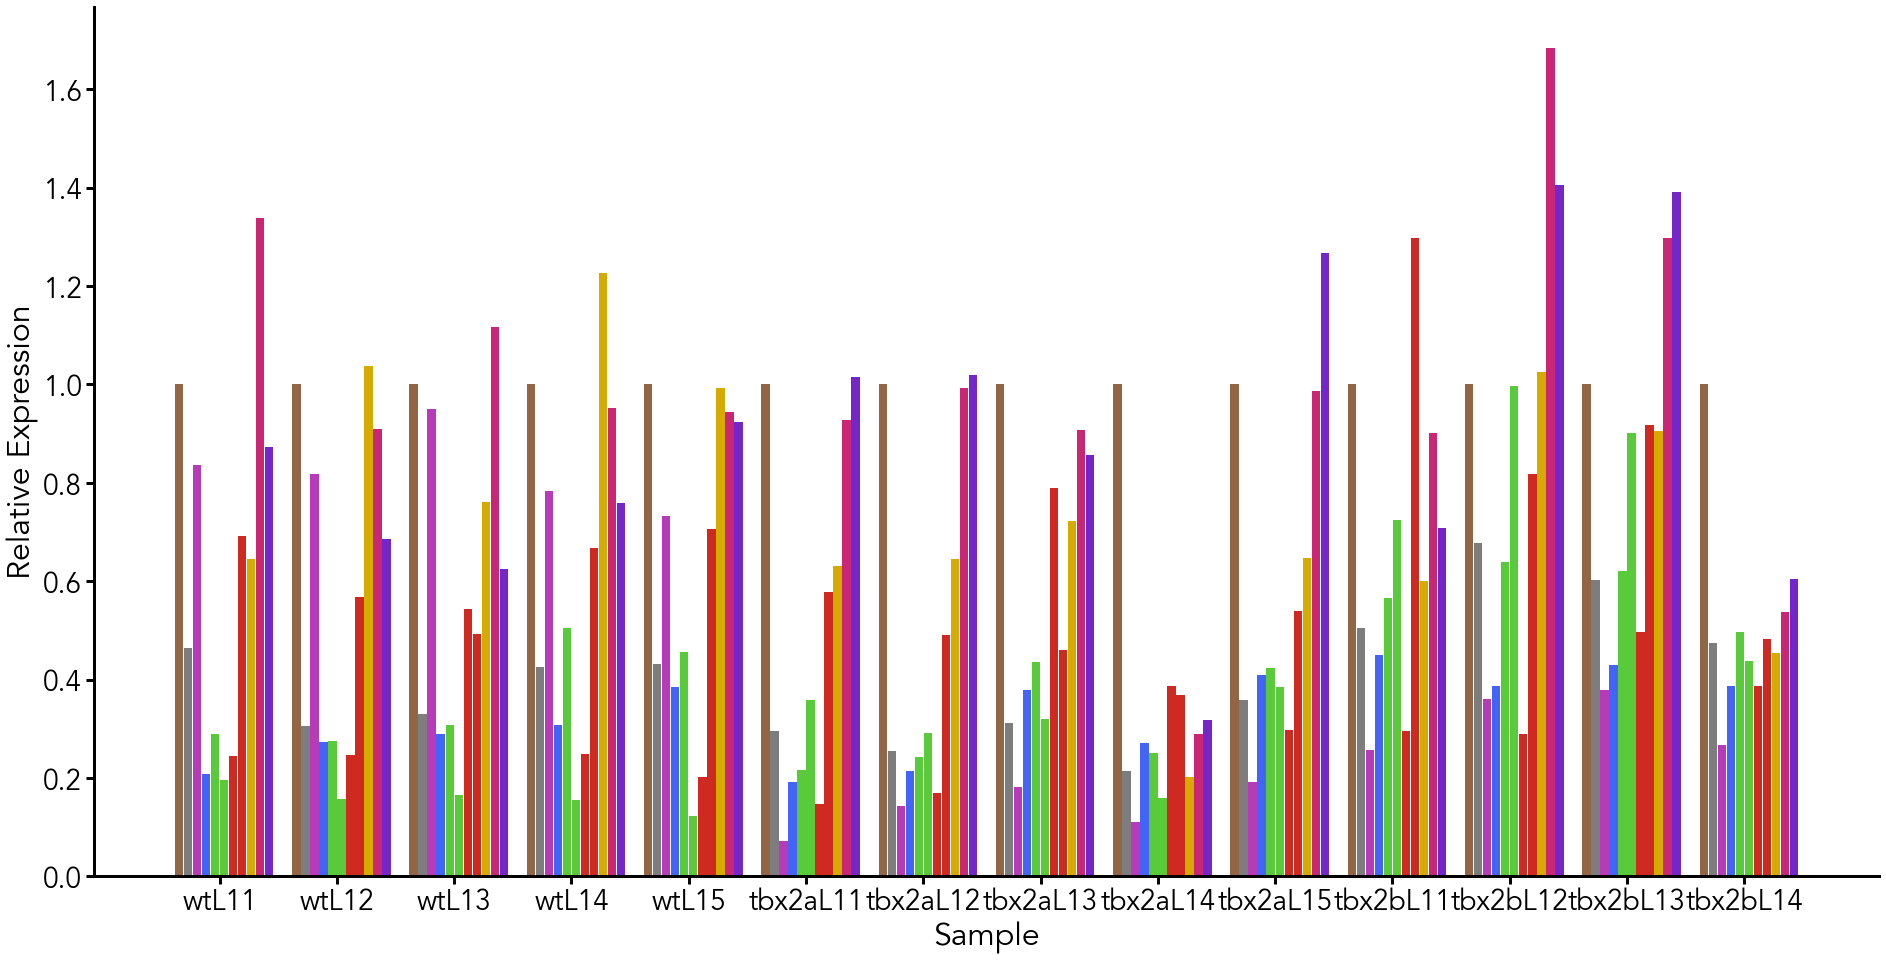

In [16]:
# grouping by sample
relW = np.size(superGeneList)+3;relD = np.size(superGeneList)+2;relP = -np.size(superGeneList)/2;
j=relP;

plotname = ''
fH, axH = plt.subplots(figsize=(32,16))
for g in superGeneList:
    i=0;
    j=j+1;
    for s in superSampleList:
        i = i+1;
        pH = plt.bar([i+j/relD], FD[s][g], width=1/relW, color=zfC[g]);

formatFigureFD(fH, axH, pH);
axH.set_xticks(range(1,np.size(superSampleList)+1));
axH.set_xticklabels(superSampleList);

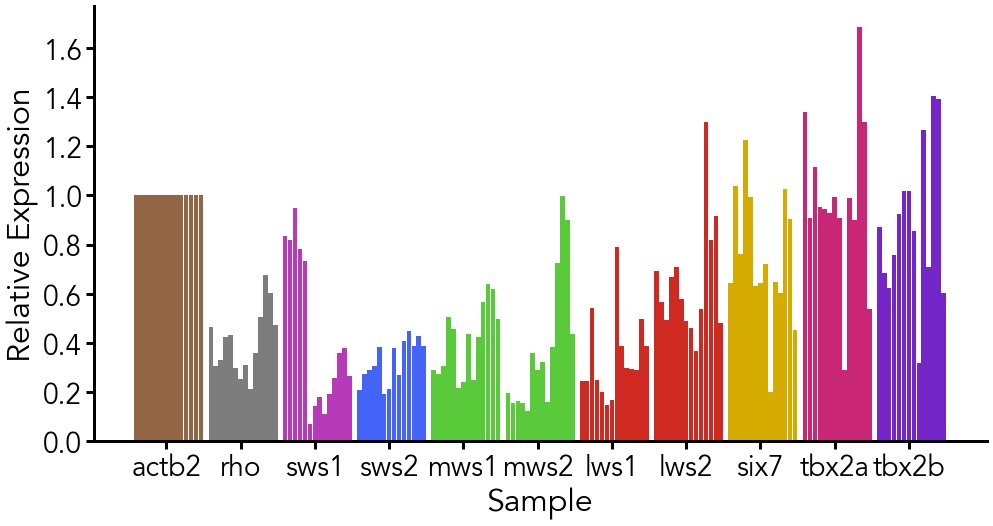

In [17]:
# grouping by gene
# superSampleList=['wtL11', 'wtL12', 'wtL13','wtL14', 'wtL15', 'wtL16', 'wtL17',
#                  'tbx2aL11', 'tbx2aL12','tbx2aL13', 'tbx2aL14','tbx2aL15','tbx2aL16','tbx2aL17',
#                  'tbx2bL11', 'tbx2bL12','tbx2bL13', 'tbx2bL14', 'tbx2bL15', 'tbx2bL16'] #re-rorganization

superSampleList=['wtL11', 'wtL12', 'wtL13','wtL14', 'wtL15',
                 'tbx2aL11', 'tbx2aL12','tbx2aL13', 'tbx2aL14','tbx2aL15',
                 'tbx2bL11', 'tbx2bL12','tbx2bL13', 'tbx2bL14',] #re-rorganization

superGeneList = ['actb2','rho','sws1','sws2','mws1','mws2','lws1','lws2','six7','tbx2a','tbx2b']

# superSampleList=['wtL11', 'wtL12', 'wtL13','wtL14', 'wtL15', 'wtL16', 'wtL17'] #re-rorganization

# superSampleList=['tbx2aL11', 'tbx2aL12','tbx2aL13', 'tbx2aL14','tbx2aL15','tbx2aL16','tbx2aL17',] #re-rorganization

# superSampleList=['wtL11', 'wtL12', 'wtL13','wtL14', 'wtL15', 'wtL16', 'wtL17','tbx2aL11', 'tbx2aL12','tbx2aL13', 'tbx2aL14','tbx2aL15','tbx2aL16','tbx2aL17',] #re-rorganization

# superGeneList = ['rho','sws1','sws2','mws1','mws2','lws1','lws2']

relW = np.size(superSampleList)+2;relD = np.size(superSampleList)+1;relP = np.floor(-np.size(superSampleList)/2);
j=relP;


plotname = ''
fH, axH = plt.subplots(figsize=(16,8))
for s in superSampleList:
    i=0;
    j=j+1;
    for g in superGeneList:
        i = i+1;
        pH = plt.bar([i+j/relD], FD[s][g], width=1/relW, color=zfC[g]);

formatFigureFD(fH, axH, pH)
axH.set_xticks(range(1,np.size(superGeneList)+1));
axH.set_xticklabels(superGeneList);

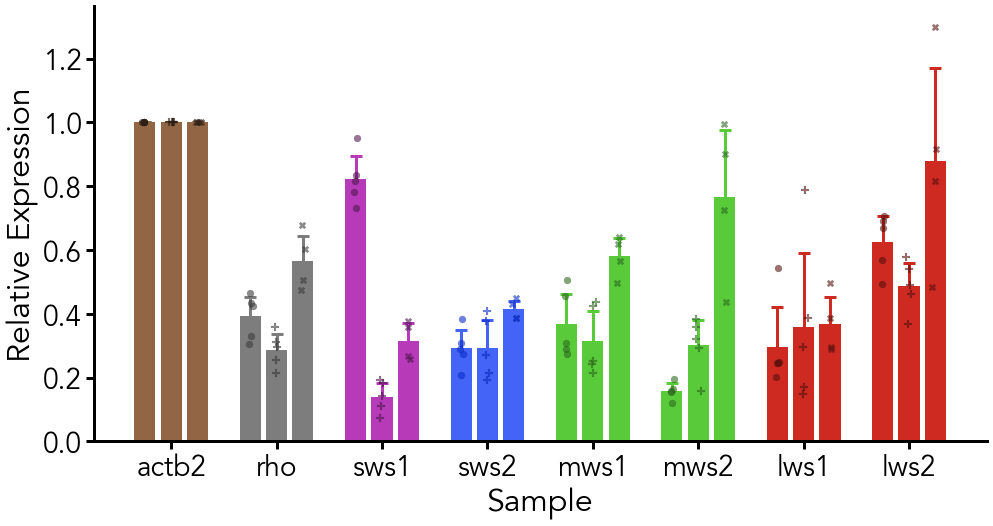

In [19]:
# finally averaging by genotype
gTypes = ['wt','tbx2a','tbx2b']
# superGeneList = ['actb2','rho','sws1','sws2','mws1','mws2','lws1','lws2', 'tbx2a', 'tbx2b', 'six7'] #
superGeneList = ['actb2','rho','sws1','sws2','mws1','mws2','lws1','lws2'] # skipping TFs for presentation


relW = np.size(gTypes)+2;relD = np.size(gTypes)+1;relP = np.floor(-np.size(gTypes)/2);
j=relP;

plotname = ''
fH, axH = plt.subplots(figsize=(16,8))
for gT in gTypes:
    i=0;
    j=j+1;
    gTS = list(filter(lambda x: gT in x, superSampleList))
    for g in superGeneList:
        i = i+1;
        pH = plt.bar([i+j/relD], np.mean(FD[gTS].loc[g]), yerr=np.std(FD[gTS].loc[g]), error_kw=dict(barsabove=True, ecolor=zfC[g], elinewidth=3, capsize = 6, capthick=3), width=1/relW, color=zfC[g], zorder=0);
        pH = plt.scatter(np.ones([1,len(gTS)])*[i+j/relD]+np.random.normal(0, .015, len(gTS)), FD[gTS].loc[g], color=lighten_color(zfC[g],1.5), zorder=1, marker = zfGm[gT], s=50, edgecolor='#000000', linewidth=0.1, alpha = .6);
        
formatFigureFD(fH, axH, pH)
axH.set_xticks(range(1,np.size(superGeneList)+1));
axH.set_xticklabels(superGeneList);


# plt.savefig("/Users/angueyraaristjm/OneDrive - National Institutes of Health/zf/Manuscripts/2021_zfConeRNAseq/resources/{0}.svg".format('qPCR_tbx2F05dpf'), transparent=True, format="svg")

### Kruskal-Wallis
> does not assume normality  
> requires at least 5 samples  
> p-value is calculated as the survival function of H, assuming it follows a $\chi^{2}$ distribution

In [31]:
statGeneList = ['rho','sws1','sws2','mws1','mws2','lws1','lws2', 'tbx2a','tbx2b','six7']
for g in statGeneList:
    wtFD = FD.loc[g][0:5]
    aFD = FD.loc[g][5:10]
    bFD = FD.loc[g][10:]

    aH, p = kruskal(wtFD, aFD, bFD)
    starstring = '---';
    if p < 0.05:
        starstring = '***'
    print('For {0}: wt vs. tbx2a vs. tbx2b: H = {1:.3f}, p = {2:.5f}. {3}'.format(g,aH,p,starstring))
    if p < 0.05:
        r = scikit_posthocs.posthoc_conover([wtFD, aFD, bFD], p_adjust='Bonferroni')
        print('\t\tConover-Iman posthoc + Bonferroni p adjustment:')
        print('\t\t\twt vs. tbx2a: p = {0:.20f} | p = {0} {1}'.format(r.iloc[0,1],('***' if (r.iloc[0,1]<0.05) else 'N.S.')))
        print('\t\t\twt vs. tbx2b: p = {0:.20f} | p = {0} {1}'.format(r.iloc[0,2],('***' if (r.iloc[0,2]<0.05) else 'N.S.')))
        print('\t\t\ttbx2a vs. tbx2b: p = {0:.20f} | p = {0} {1}'.format(r.iloc[1,2],('***' if (r.iloc[1,2]<0.05) else 'N.S.')))

        r = scikit_posthocs.posthoc_dunn([wtFD, aFD, bFD], p_adjust='Bonferroni')
        print('\t\tDunn posthoc + Bonferroni p adjustment:')
        print('\t\t\twt vs. tbx2a: p = {0:.20f} | p = {0} {1}'.format(r.iloc[0,1],('***' if (r.iloc[0,1]<0.05) else 'N.S.')))
        print('\t\t\twt vs. tbx2b: p = {0:.20f} | p = {0} {1}'.format(r.iloc[0,2],('***' if (r.iloc[0,2]<0.05) else 'N.S.')))
        print('\t\t\ttbx2a vs. tbx2b: p = {0:.20f} | p = {0} {1}'.format(r.iloc[1,2],('***' if (r.iloc[1,2]<0.05) else 'N.S.')))


For rho: wt vs. tbx2a vs. tbx2b: H = 10.063, p = 0.00653. ***
		Conover-Iman posthoc + Bonferroni p adjustment:
			wt vs. tbx2a: p = 0.05375873860880663047 | p = 0.05375873860880663 N.S.
			wt vs. tbx2b: p = 0.01447020580697787329 | p = 0.014470205806977873 ***
			tbx2a vs. tbx2b: p = 0.00022005325511192676 | p = 0.00022005325511192676 ***
		Dunn posthoc + Bonferroni p adjustment:
			wt vs. tbx2a: p = 0.45278085020014879891 | p = 0.4527808502001488 N.S.
			wt vs. tbx2b: p = 0.20747847582292119895 | p = 0.2074784758229212 N.S.
			tbx2a vs. tbx2b: p = 0.00454961493512543065 | p = 0.004549614935125431 ***
For sws1: wt vs. tbx2a vs. tbx2b: H = 11.571, p = 0.00307. ***
		Conover-Iman posthoc + Bonferroni p adjustment:
			wt vs. tbx2a: p = 0.00000393562584275394 | p = 3.93562584275394e-06 ***
			wt vs. tbx2b: p = 0.00293745055820013789 | p = 0.002937450558200138 ***
			tbx2a vs. tbx2b: p = 0.00293745055820013789 | p = 0.002937450558200138 ***
		Dunn posthoc + Bonferroni p adjustment:
			wt v

### Mann-Whitney U
> originally used to avoid assumptions of normality  
> reviewer pointed out sensitivity to big differences in variance and recommended Kruskal-Wallis test

In [13]:
statGeneList = ['rho','sws1','sws2','mws1','mws2','lws1','lws2']
for g in statGeneList:
    wtFD = FD.loc[g][0:5]
    aFD = FD.loc[g][5:10]
    bFD = FD.loc[g][10:]

    U1, p = mannwhitneyu(wtFD, aFD)
    print('For {0}: wt vs. tbx2a: U = {1}, p = {2}'.format(g,U1,p))
    U1, p = mannwhitneyu(wtFD, bFD)
    print('For {0}: wt vs. tbx2b: U = {1}, p = {2}\n'.format(g,U1,p))


For rho: wt vs. tbx2a: U = 22.0, p = 0.05555555555555555
For rho: wt vs. tbx2b: U = 0.0, p = 0.015873015873015872

For sws1: wt vs. tbx2a: U = 25.0, p = 0.007936507936507936
For sws1: wt vs. tbx2b: U = 20.0, p = 0.015873015873015872

For sws2: wt vs. tbx2a: U = 14.0, p = 0.8412698412698413
For sws2: wt vs. tbx2b: U = 0.0, p = 0.015873015873015872

For mws1: wt vs. tbx2a: U = 19.0, p = 0.2222222222222222
For mws1: wt vs. tbx2b: U = 1.0, p = 0.031746031746031744

For mws2: wt vs. tbx2a: U = 2.0, p = 0.031746031746031744
For mws2: wt vs. tbx2b: U = 0.0, p = 0.015873015873015872

For lws1: wt vs. tbx2a: U = 12.0, p = 1.0
For lws1: wt vs. tbx2b: U = 4.0, p = 0.19047619047619047

For lws2: wt vs. tbx2a: U = 22.0, p = 0.05555555555555555
For lws2: wt vs. tbx2b: U = 5.0, p = 0.2857142857142857



In [ ]:
pwd

## Standard Curve Method: step-by-step analysis for Quality Control

### Load data, extract standard samples and fit to line (in log10(dilutions) space)

In [ ]:
dName = "/Users/angueyraaristjm/Documents/LiMolec/zfqPCR/BioRad/"

# fName = "20210419_CRtbx2F0s_rhos1_stdCurve.csv"
# geneList = ['actb2','rho','sws1']
# fName = "20210419_CRtbx2F0s_m2l2_stdCurve.csv"
# geneList = ['actb2','mws2','lws2']
# fName = "20210419_CRtbx2F0s_s2m1_stdCurve.csv"
# geneList = ['actb2','sws2','mws1']
# fName = "20210419_CRtbx2F0s_six7l1_stdCurve.csv"
# geneList = ['actb2','six7','lws1']
# fName = "20210505_CRtbx2F0s_tbx2ab_stdCurve.csv"
# geneList = ['actb2','tbx2a','tbx2b']
# sampleList=['wtL11', 'wtL12', 'wtL13','tbx2aL11', 'tbx2aL12', 'tbx2bL11', 'tbx2bL12'] #re-rorganization

# fName = "20210423_CRtbx2F0s_rhos1_stdCurve.csv"
# geneList = ['actb2','rho','sws1']
# fName = "20210423_CRtbx2F0s_m2l2_stdCurve.csv"
# geneList = ['actb2','mws2','lws2']
# fName = "20210423_CRtbx2F0s_s2m1_stdCurve.csv"
# geneList = ['actb2','sws2','mws1']
# fName = "20210423_CRtbx2F0s_six7l1_stdCurve.csv"
# geneList = ['actb2','six7','lws1']
# fName = "20210507_CRtbx2F0s_tbx2ab_stdCurve.csv"
# geneList = ['actb2','tbx2a','tbx2b']
# sampleList=['wtL14', 'wtL15', 'tbx2aL13', 'tbx2aL14', 'tbx2aL15', 'tbx2bL13', 'tbx2bL14'] #re-rorganization


fName = "20210507_CRtbx2F0s_rhos1_stdCurve.csv"
geneList = ['actb2','rho','sws1']
fName = "20210507_CRtbx2F0s_m2l2_stdCurve.csv"
geneList = ['actb2','mws2','lws2']
fName = "20210507_CRtbx2F0s_s2m1_stdCurve.csv"
geneList = ['actb2','sws2','mws1']
fName = "20210507_CRtbx2F0s_six7l1_stdCurve.csv"
geneList = ['actb2','six7','lws1']
# fName = "20210512_CRtbx2F0s_tbx2ab_stdCurve.csv"
# geneList = ['actb2','tbx2a','tbx2b']
sampleList=['wtL16', 'wtL17','tbx2aL16', 'tbx2aL17', 'tbx2bL15','tbx2bL16']

df = pd.read_csv(dName + fName)
# df[df['Sample']=='std01']

plotname = ''
fH, ax = plt.subplots()

stdc={}
stdc['gene'] = geneList
stdc['dLin'] = np.linspace(-5,-1,10)
# stdc['dilutions'] = np.log10([1/10,1/30,1/100,1/300,1/1000,1/3000,1/10,1/30,1/100,1/300,1/1000,1/3000])
stdc['dilutions'] = np.log10([1/30,1/1e2,1/1e3,1/1e4,1/1e5,1/30,1/1e2,1/1e3,1/1e4,1/1e5])
for g in geneList:
    stdc[g] = df[(df['Sample']=='std01') & (df['Target']==g)].Cq.values
    # linear fit and ignoring NaN
    stdc[g + 'm'], stdc[g + 'p'] = np.polyfit(stdc['dilutions'][~np.isnan(stdc[g])], stdc[g][~np.isnan(stdc[g])], 1)
    pH = plt.scatter(stdc['dilutions'], stdc[g], color = zfC[g])
    pH = plt.plot(stdc['dLin'], stdc[g + 'm']*stdc['dLin']+stdc[g + 'p'], color = zfC[g])

ax.set_xlabel('log(Dilution)')
ax.set_ylabel('Ct')
ax.legend(geneList, frameon=False)
formatFigureMain(fH, ax, pH);
# stdc

### Interpolate StdDilution for each sample (and check consistency)

In [ ]:
# interpolation of dilution relative to standard diltuion curve


stdCt={}
stdCt['samples'] = sampleList

plotname = ''
fH, ax = plt.subplots(1,len(sampleList),figsize = (5*len(sampleList),6))
ax[0].set_ylabel('Ct')
for g in geneList:
    for a in ax:
        pH = a.plot(stdc['dLin'], stdc[g + 'm']*stdc['dLin']+stdc[g + 'p'], color = zfC[g]) #plot only lines of stdCurve
    a = -1;
    for s in sampleList:
        a = a+1;
        stdCt[s + g] = df[(df['Sample']==s) & (df['Target']==g)].Cq.values
        stdCt[s + g + 'std'] = (stdCt[s + g]-stdc[g + 'p'])/stdc[g + 'm']
        pH = ax[a].scatter((stdCt[s + g + 'std']), (stdCt[s + g]), color=zfC[g])
        ax[a].set_xlabel('log(Dilution)')
        fontP = formatFigureMain(fH, ax[a], pH);
        ax[a].set_title(s, fontproperties = fontP)
ax[a].legend(geneList, frameon=False);
# stdCt  

### Check results (fold-difference expression to selected house-keeping gene)

In [ ]:
# Normalization to house keeping gene (using averages now)
hkg = 'actb2'

plotname = ''
fH, axH = plt.subplots(figsize=(16,6))

relW = np.size(geneList)+2;relD = np.size(geneList)+1;relP = -np.size(geneList)+1;
j=relP;

FD={}

for g in geneList:
    i=0;
    j=j+1;
    for s in sampleList:
        i = i+1;
        FD[s + g ] = np.power(10,np.nanmean(stdCt[s + g + 'std']))/np.power(10,np.nanmean(stdCt[s + hkg + 'std']))
        FD[s + g + 'SD'] = 0 #missing calculation here
        pH = plt.bar([i+j/relD], FD[s + g], width=1/relW, color=zfC[g]);
     
formatFigureFD(fH, axH, pH)
axH.set_xticks(range(1,np.size(sampleList)+1));
axH.set_xticklabels(sampleList);
# axH.set_ylim([0,2.5]);
# FD

In [ ]:
plotname = ''
fH, ax = plt.subplots()

# ax.legend((pH1, pH2, pH3,pH4,pH5,pH6,pH7,pH8),('wt3','wt4','wt5','2a3','2a4','2a5','2b1','2b2'),loc='best',ncol=2)

## Std curve to figure out dilutions

In [ ]:
batlow = cm.vik(range(255))
batlow = batlow[0:255:int(np.floor(255/8)),:]
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=batlow) 


def formatFigure(figH, axH, plotH):
    font_path = '/System/Library/Fonts/Avenir.ttc'
    fontTicks = font_manager.FontProperties(fname=font_path, size=18)
    fontLabels = font_manager.FontProperties(fname=font_path, size=22)
    fontTitle = font_manager.FontProperties(fname=font_path, size=28)
    axH.set_xscale('linear')
    axH.set_ylabel('Ct', fontproperties=fontLabels)
    axH.set_ylabel('Dilution', fontproperties=fontLabels)
    axH.spines['top'].set_visible(False)
    axH.spines['right'].set_visible(False)
    
    

    for label in (axH.get_xticklabels() + axH.get_yticklabels()):
        label.set_fontproperties(fontTicks)

In [ ]:
df = pd.read_csv("/Users/angueyraaristjm/Documents/LiMolec/zfqPCR/BioRad/20210324_CRtbx2F0_stdCurve_actb2_six7.csv")
df[df['Target']=='actb2']

In [ ]:
wtL03 = df[(df['Sample']=='wtL03') & (df['Target']=='actb2')].Cq
wtL04 = df[(df['Sample']=='wtL04') & (df['Target']=='actb2')].Cq
wtL05 = df[(df['Sample']=='wtL05') & (df['Target']=='actb2')].Cq
tbx2aL03 = df[(df['Sample']=='tbx2aL03') & (df['Target']=='actb2')].Cq
tbx2aL04 = df[(df['Sample']=='tbx2aL04') & (df['Target']=='actb2')].Cq
tbx2aL05 = df[(df['Sample']=='tbx2aL05') & (df['Target']=='actb2')].Cq
tbx2bL01 = df[(df['Sample']=='tbx2bL01') & (df['Target']=='actb2')].Cq
tbx2bL02 = df[(df['Sample']=='tbx2bL02') & (df['Target']=='actb2')].Cq



In [ ]:
mwtL03, bwtL03 = np.polyfit(dilutions, wtL03 , 1)
mwtL04, bwtL04 = np.polyfit(dilutions, wtL04 , 1)
mwtL05, bwtL05 = np.polyfit(dilutions, wtL05 , 1)
mtbx2aL03, btbx2aL03 = np.polyfit(dilutions[~np.isnan(tbx2aL03)], tbx2aL03[~np.isnan(tbx2aL03)] , 1)
mtbx2aL04, btbx2aL04 = np.polyfit(dilutions, tbx2aL04 , 1)
mtbx2aL05, btbx2aL05 = np.polyfit(dilutions, tbx2aL05 , 1)
mtbx2bL01, btbx2bL01 = np.polyfit(dilutions, tbx2bL01 , 1)
mtbx2bL02, btbx2bL02 = np.polyfit(dilutions, tbx2bL02 , 1)

In [ ]:
#pyplot version (Sep_2019)
plotname = ''
fH, ax = plt.subplots()
pH1 = plt.scatter(dilutions, wtL03)
pH2 = plt.scatter(dilutions, wtL04)
pH3 = plt.scatter(dilutions, wtL05)
pH4 = plt.scatter(dilutions, tbx2aL03)
pH5 = plt.scatter(dilutions, tbx2aL04)
pH6 = plt.scatter(dilutions, tbx2aL05)
pH7 = plt.scatter(dilutions, tbx2bL01)
pH8 = plt.scatter(dilutions, tbx2bL02)
pH9 = plt.plot(dilutions, mwtL03*dilutions + bwtL03)
pH = plt.plot(dilutions, mwtL04*dilutions + bwtL04)
pH = plt.plot(dilutions, mwtL05*dilutions + bwtL05)
pH = plt.plot(dilutions, mtbx2aL03*dilutions + btbx2aL03)
pH = plt.plot(dilutions, mtbx2aL04*dilutions + btbx2aL04)
pH = plt.plot(dilutions, mtbx2aL05*dilutions + btbx2aL05)
pH = plt.plot(dilutions, mtbx2bL01*dilutions + btbx2bL01)
pH = plt.plot(dilutions, mtbx2bL02*dilutions + btbx2bL02)
formatFigure(fH, ax, pH)
ax.legend((pH1, pH2, pH3,pH4,pH5,pH6,pH7,pH8),('wt3','wt4','wt5','2a3','2a4','2a5','2b1','2b2'),loc='best',ncol=2)
# plt.tight_layout()

In [ ]:
[mwtL03,mwtL04,mwtL05,mtbx2aL03,mtbx2aL04,mtbx2aL05,mtbx2bL01,mtbx2bL02]